# Preparing Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
dataset = pd.read_csv('churn.csv')
dataset.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Inconsistent Value

In [ ]:
categoric_columns = dataset.select_dtypes('object').columns.to_list()
for column in categoric_columns:
  if column != 'customerID':
    print(f"===================  {column}  ===================")
    display(dataset[column].value_counts().reset_index())
    print("")
    print("")

===================  Gender  ===================


,Gender,count
0,Male,3552
1,Female,3478




===================  Partner  ===================


,Partner,count
0,No,3638
1,Yes,3392




===================  Dependents  ===================


,Dependents,count
0,No,4931
1,Yes,2096




===================  Contract  ===================


,Contract,count
0,Month-to-month,3873
1,Two year,1689
2,One year,1471




===================  PaperlessBilling  ===================


,PaperlessBilling,count
0,Yes,4168
1,No,2865




===================  PaymentMethod  ===================


,PaymentMethod,count
0,Electronic check,2367
1,Mailed check,1604
2,Bank transfer (automatic),1540
3,Credit card (automatic),1524




===================  Churn  ===================


,Churn,count
0,No,5174
1,Yes,1872


All values in each feature are already consistent.

## Split Data

Data splitting is done at the beginning (before handling missing values) because the values/information used to fill in missing values will only come from the training set. This prevents test set information leakage (data leakage).

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns=['customerID', 'Churn'])
y = dataset[['Churn']]

# First splitting: pretrain and test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Second splitting: train and validation
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((4508, 10), (1128, 10), (1410, 10))

## Missing Value

In [ ]:
dataset_train = pd.concat([X_train, y_train], axis=1)
dataset_val = pd.concat([X_val, y_val], axis=1)
dataset_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
# Missing value checking
missing_dataset = pd.DataFrame({'Data Type': dataset_train.dtypes,
                                'Missing Percentage (Train)': dataset_train.isnull().sum() / len(dataset_train) * 100,
                                'Missing Percentage (Val)': dataset_val.isnull().sum() / len(dataset_val) * 100,
                                'Missing Percentage (Test)': dataset_test.isnull().sum() / len(dataset_test) * 100,
                                }).reset_index().rename(columns={'index': 'Feature'})
missing_dataset[['Missing Percentage (Train)', 'Missing Percentage (Val)', 'Missing Percentage (Test)']] = missing_dataset[['Missing Percentage (Train)', 'Missing Percentage (Val)', 'Missing Percentage (Test)']].map('{:.3f}%'.format)
display(missing_dataset)

,Feature,Data Type,Missing Percentage (Train),Missing Percentage (Val),Missing Percentage (Test)
0,Gender,object,0.266%,0.177%,0.142%
1,SeniorCitizen,float64,0.222%,0.089%,0.071%
2,Partner,object,0.177%,0.355%,0.284%
3,Dependents,object,0.333%,0.177%,0.142%
4,Tenure,float64,0.244%,0.089%,0.355%
5,Contract,object,0.177%,0.266%,0.142%
6,PaperlessBilling,object,0.222%,0.177%,0.071%
7,PaymentMethod,object,0.177%,0.000%,0.213%
8,MonthlyCharges,float64,0.111%,0.177%,0.213%
9,TotalCharges,float64,0.000%,0.000%,0.000%


Since the percentage of missing values in all the features above is less than 20%, handling will be done as follows:
- Filling missing values with the mode for categorical data (object)
- Filling missing values with the mean for numerical data (float and int)

In [ ]:
# Handling missing value

## Object data type (using mode)
### Training dataset
object_column_train = missing_dataset[missing_dataset['Data Type'] == 'object']['Feature'].to_list()
mode_object_column = {col: dataset_train[~dataset_train[col].isnull()][col].mode()[0] for col in object_column_train}
for col in object_column_train:
  dataset_train[col] = dataset_train[col].fillna(mode_object_column[col])

### Applying mode from the training dataset to the validation dataset
object_column_val = missing_dataset[missing_dataset['Data Type'] == 'object']['Feature'].to_list()
for col in object_column_val:
  dataset_val[col] = dataset_val[col].fillna(mode_object_column[col])

### Applying mode from the training dataset to the test dataset
object_column_test = missing_dataset[missing_dataset['Data Type'] == 'object']['Feature'].to_list()
for col in object_column_test:
  dataset_test[col] = dataset_test[col].fillna(mode_object_column[col])

In [ ]:
## SeniorCitizen column (since it's a boolean, it uses mode)
### Training dataset
sc_mode = dataset_train[~dataset_train['SeniorCitizen'].isnull()]['SeniorCitizen'].mode()[0]
dataset_train['SeniorCitizen'] = dataset_train['SeniorCitizen'].fillna(sc_mode)

### Applying mode from the training dataset to the validation dataset
dataset_val['SeniorCitizen'] = dataset_val['SeniorCitizen'].fillna(sc_mode)

### Applying mode from the training dataset to the test dataset
dataset_test['SeniorCitizen'] = dataset_test['SeniorCitizen'].fillna(sc_mode)

At a glance and from a business insight perspective, the TotalCharges value is still related to Tenure and MonthlyCharges. The amount is slightly higher than (Tenure × MonthlyCharges), possibly due to additional costs. Therefore:
- To fill missing values for Tenure, the formula TotalCharges / MonthlyCharges will be used.
- To fill missing values for MonthlyCharges, the formula TotalCharges / Tenure will be used.

In [ ]:
## Tenure column
dataset_train['Tenure'] = dataset_train['Tenure'].fillna(dataset_train['TotalCharges'] / dataset_train['MonthlyCharges'])
dataset_val['Tenure'] = dataset_val['Tenure'].fillna(dataset_val['TotalCharges'] / dataset_val['MonthlyCharges'])
dataset_test['Tenure'] = dataset_test['Tenure'].fillna(dataset_test['TotalCharges'] / dataset_test['MonthlyCharges'])

In [ ]:
## MonthlyCharges column
dataset_train['MonthlyCharges'] = dataset_train['MonthlyCharges'].fillna(dataset_train['TotalCharges'] / dataset_train['Tenure'])
dataset_val['MonthlyCharges'] = dataset_val['MonthlyCharges'].fillna(dataset_val['TotalCharges'] / dataset_val['Tenure'])
dataset_test['MonthlyCharges'] = dataset_test['MonthlyCharges'].fillna(dataset_test['TotalCharges'] / dataset_test['Tenure'])

In [ ]:
# Checking missing value after handling
pd.DataFrame({'Data Type': dataset_train.dtypes,
              'Missing Count (Train)': (dataset_train.isnull().sum()),
              'Missing Count (Val)': (dataset_val.isnull().sum()),
              'Missing Count (Test)': (dataset_test.isnull().sum()),
              }).reset_index().rename(columns={'index': 'Feature'})

,Feature,Data Type,Missing Count (Train),Missing Count (Val),Missing Count (Test)
0,Gender,object,0,0,0
1,SeniorCitizen,float64,0,0,0
2,Partner,object,0,0,0
3,Dependents,object,0,0,0
4,Tenure,float64,0,0,0
5,Contract,object,0,0,0
6,PaperlessBilling,object,0,0,0
7,PaymentMethod,object,0,0,0
8,MonthlyCharges,float64,0,0,0
9,TotalCharges,float64,0,0,0


Great! All missing values have been handled. Now you have a complete dataset ready for further analysis or modeling.

## Duplicate Data

Duplicate data could actually be handled before splitting the data. However, in this case, the researcher chose to drop duplicates after ensuring there were no missing values. The result remains the same.

In [ ]:
# Checking total duplicate value
print(f'Total duplicate value in the training dataset: {dataset_train.duplicated().sum()}')
print(f'Total duplicate value in the validation dataset: {dataset_val.duplicated().sum()}')
print(f'Total duplicate value in the test dataset: {dataset_test.duplicated().sum()}')

Total duplicate value in the training dataset: 18
Total duplicate value in the validation dataset: 0
Total duplicate value in the test dataset: 3


In [ ]:
# Remove duplicate value
dataset_train.drop_duplicates(inplace=True)
dataset_test.drop_duplicates(inplace=True)

print(f'Total duplicate value in the training dataset (after handling): {dataset_train.duplicated().sum()}')
print(f'Total duplicate value in the test dataset (after handling): {dataset_test.duplicated().sum()}')

Total duplicate value in the training dataset (after handling): 0
Total duplicate value in the test dataset (after handling): 0


## Outlier

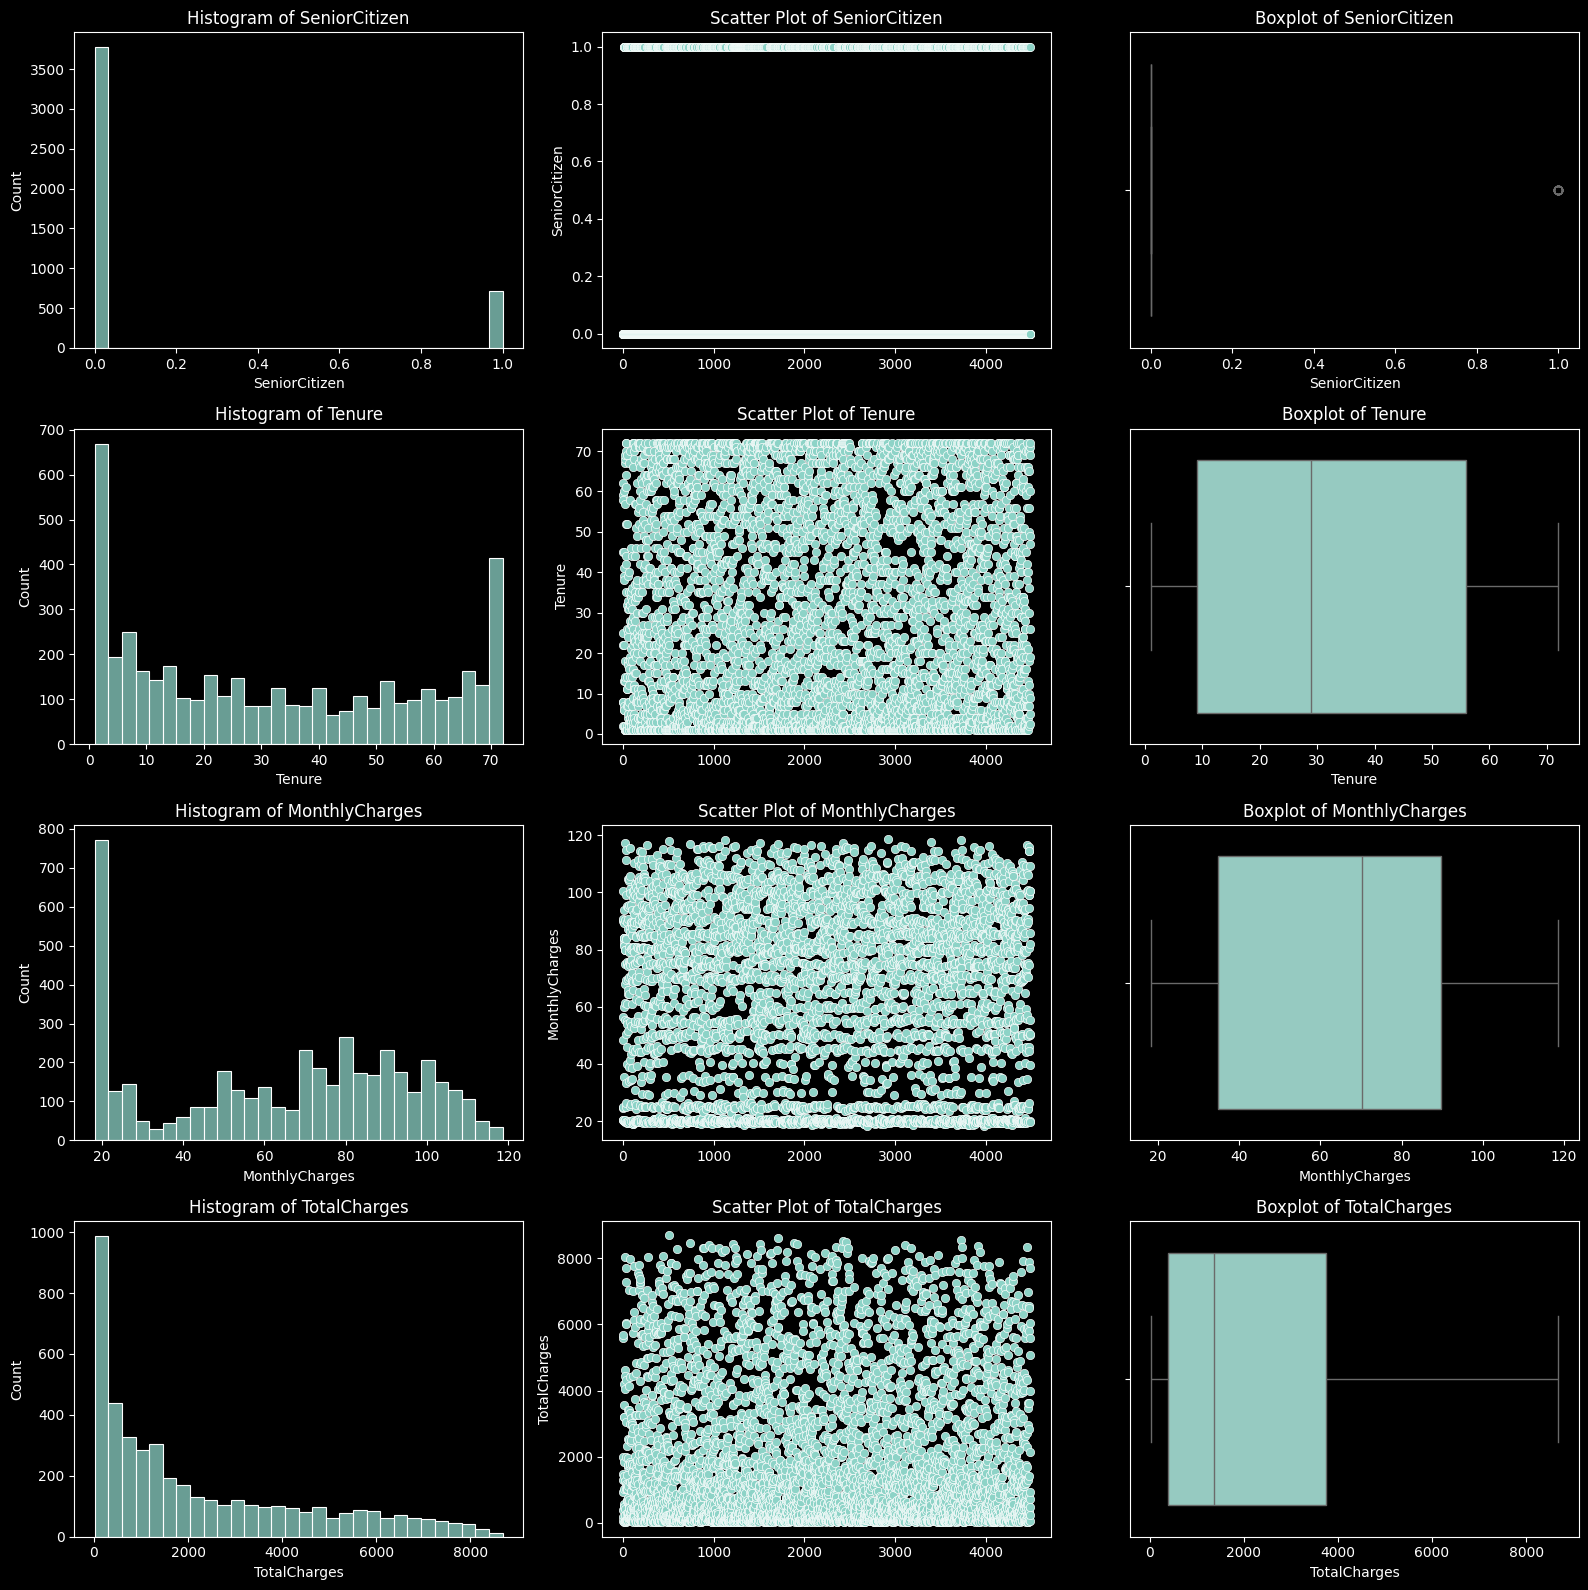

In [ ]:
# Outlier

def distribution_plot(data, variable):
  fig, axes = plt.subplots(nrows=len(variable), ncols=3, figsize=(16,4*len(variable)))
  plt.style.use('dark_background')
  for i in range(0, len(variable)):
    # Histogram
    sns.histplot(data[variable[i]], bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {variable[i]}")
    # Sctter plot
    sns.scatterplot(x=range(len(data[variable[i]])), y=data[variable[i]], ax=axes[i, 1])
    axes[i, 1].set_title(f"Scatter Plot of {variable[i]}")
    # Box plot
    sns.boxplot(data[variable[i]], orient='h', ax=axes[i, 2])
    axes[i, 2].set_title(f"Boxplot of {variable[i]}")
  plt.tight_layout()
  plt.show()

variable = dataset_train.select_dtypes(include='number').columns
distribution_plot(dataset_train, variable)

From the boxplot, there are no values beyond the tails or outside the upper and lower limits of the boxplot, indicating that there are no outliers in the data. Although the data distribution is concentrated around a single point, the histogram's range is not wide, confirming that no outliers are present.

## Encoding

In [ ]:
# Copy of data
df_train = dataset_train.copy()
df_val = dataset_val.copy()
df_test = dataset_test.copy()

# OHE on gender feature
df_train = pd.get_dummies(df_train, columns=['Gender'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['Gender'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Gender'], drop_first=True)

# Change the data types
df_train['Gender_Male'] = df_train['Gender_Male'].astype(int)
df_val['Gender_Male'] = df_val['Gender_Male'].astype(int)
df_test['Gender_Male'] = df_test['Gender_Male'].astype(int)

In [ ]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = df_train.select_dtypes('object').columns.to_list()
label_encoders = {}
for column in columns_to_encode:
    le = LabelEncoder()
    df_train[column] = le.fit_transform(df_train[column])
    label_encoders[column] = le

for column in columns_to_encode:
    df_val[column] = label_encoders[column].transform(df_val[column])

for column in columns_to_encode:
    df_test[column] = label_encoders[column].transform(df_test[column])

# Multicollinearity Check

In [ ]:
# Calculating VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X_const = add_constant(df_train.drop(columns=['Churn']))
vif_df = pd.DataFrame([vif(X_const.values, i)
               for i in range(X_const.shape[1])],
              index=X_const.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,SeniorCitizen,1.125346
2,Partner,1.464168
3,Dependents,1.357127
4,Tenure,7.160712
5,Contract,2.141989
6,PaperlessBilling,1.179410
7,PaymentMethod,1.182269
8,MonthlyCharges,3.652142
9,TotalCharges,9.562282
10,Gender_Male,1.003604


There are two features with a VIF greater than 4:
- Tenure (7.160712)
- TotalCharges (9.562282)

Further analysis using a correlation heatmap is needed to assess their relationship with other variables. This will help determine if multicollinearity is a concern and whether adjustments, such as feature selection or transformation, are required.

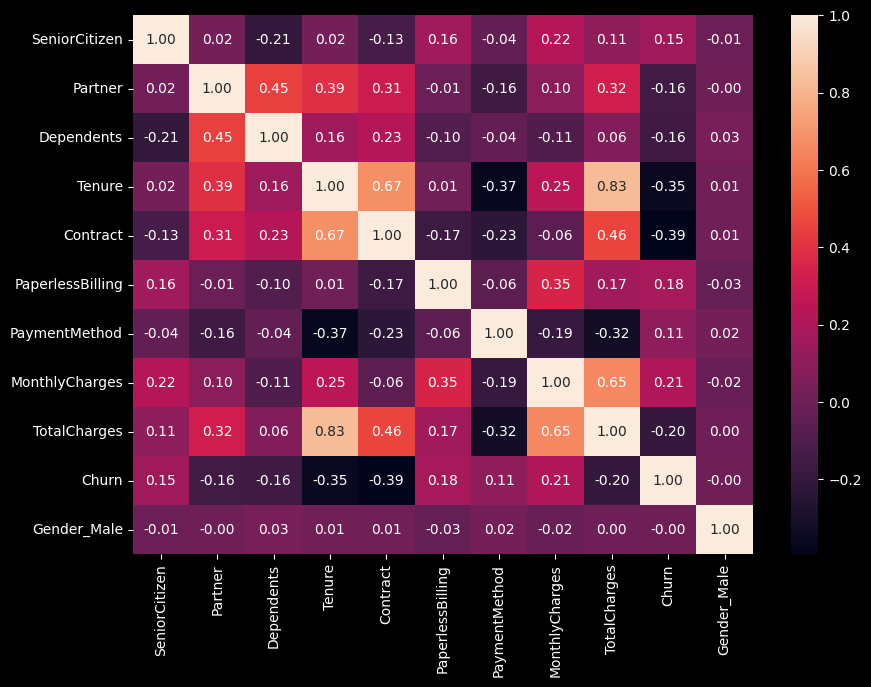

In [ ]:
# Heatmap correlation
corr = df_train.corr()

plt.figure(figsize=(10,7))
plt.style.use('dark_background')
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Tenure and TotalCharges have a high correlation, so one of them needs to be dropped. However, this will only be applied in logistic regression modeling, as logistic regression is a linear model where each feature is assumed to contribute independently to the logit (log-odds). If there is correlation between features, it can lead to unstable parameter estimation and significance testing.

Meanwhile, for decision tree, random forest, and XGBoost models, this correlation is less impactful because these methods split at each node based on a single feature. Although it can affect tree depth (DT model—which can be managed with tuning) and final interpretation (RF and XGB models), it does not significantly affect model performance.

The feature to be dropped in logistic regression modeling is TotalCharges, as it has a lower correlation with the target variable (Churn).

# Imbalanced Data

In [ ]:
df_train['Churn'].value_counts().reset_index()

,Churn,count
0,0,3317
1,1,1173


The Churn (1) and Non-Churn (0) categories appear to be imbalanced. This imbalance can cause the model to lean heavily toward the majority class, making it likely to predict all data as Non-Churn while still achieving high accuracy. However, misclassifying churned customers as non-churn can be highly detrimental from a business perspective. Therefore, handling imbalanced data is necessary, and one approach is undersampling, which helps prevent overfitting that might occur with oversampling methods.

In [ ]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

X_train = df_train.drop(['Churn'], axis=1)
y_train = df_train['Churn']

# Undersampling
X_train_under, y_train_under = under_sampling.RandomUnderSampler().fit_resample(X_train, y_train)
df_train_under = pd.concat([X_train_under, y_train_under], axis=1)

In [ ]:
print('Churn label distribution after undersampling')
print(df_train_under['Churn'].value_counts().reset_index())

Churn label distribution after undersampling
   Churn  count
0      0   1173
1      1   1173


# Modeling

## Logistic Regression

In [ ]:
train_logreg = df_train_under.copy()
val_logreg = df_val.copy()
test_logreg = df_test.copy()

# Split data
## Train
X_train_logreg = train_logreg.drop(['Churn', 'TotalCharges'], axis=1)
y_train_logreg = train_logreg['Churn']
## Validation
X_val_logreg = val_logreg.drop(['Churn', 'TotalCharges'], axis=1)
y_val_logreg = val_logreg['Churn']
## Test
X_test_logreg = test_logreg.drop(['Churn', 'TotalCharges'], axis=1)
y_test_logreg = test_logreg['Churn']

### Without Tuning

In [ ]:
# Logreg without tuning

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## Training model baseline
logreg_baseline = LogisticRegression( random_state=42)
logreg_baseline.fit(X_train_logreg, y_train_logreg)

## Evaluate
y_train_pred_logreg_baseline = logreg_baseline.predict(X_train_logreg)
y_val_pred_logreg_baseline = logreg_baseline.predict(X_val_logreg)
y_test_pred_logreg_baseline = logreg_baseline.predict(X_test_logreg)
print("Recall Train      : ", recall_score(y_train_logreg, y_train_pred_logreg_baseline))
print("Recall Val        : ", recall_score(y_val_logreg, y_val_pred_logreg_baseline))
print("Recall Test       : ", recall_score(y_test_logreg, y_test_pred_logreg_baseline))
print("Precision Test    : ", precision_score(y_test_logreg, y_test_pred_logreg_baseline))

Recall Train      :  0.8073316283034954
Recall Val        :  0.7877813504823151
Recall Test       :  0.7851458885941645
Precision Test    :  0.5


### With Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Training model and tuning hyperparameter
model_logreg = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
param_logreg = {'penalty': ['l1', 'l2'],
                'C': [0.01, 0.1, 1, 10]}
logreg_cv = GridSearchCV(model_logreg, param_logreg, cv=5, scoring='recall')
logreg_cv.fit(X_train_logreg, y_train_logreg)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='recall')

In [ ]:
# Evaluate
y_train_pred_logreg = logreg_cv.predict(X_train_logreg)
y_val_pred_logreg = logreg_cv.predict(X_val_logreg)
y_test_pred_logreg = logreg_cv.predict(X_test_logreg)

print("Best params       : ", logreg_cv.best_params_)
print("Recall Train      : ", recall_score(y_train_logreg, y_train_pred_logreg))
print("Recall Val        : ", recall_score(y_val_logreg, y_val_pred_logreg))
print("Recall Test       : ", recall_score(y_test_logreg, y_test_pred_logreg))
print("Precision Test    : ", precision_score(y_test_logreg, y_test_pred_logreg))

Best params       :  {'C': 0.1, 'penalty': 'l1'}
Recall Train      :  0.8226768968456948
Recall Val        :  0.7909967845659164
Recall Test       :  0.7877984084880637
Precision Test    :  0.4991596638655462


## Decission Tree

In [ ]:
train_dt = df_train_under.copy()
val_dt = df_val.copy()
test_dt = df_test.copy()

# Split data
## Train
X_train_dt = train_dt.drop('Churn', axis=1)
y_train_dt = train_dt['Churn']
## Validation
X_val_dt = val_dt.drop('Churn', axis=1)
y_val_dt = val_dt['Churn']
## Test
X_test_dt = test_dt.drop('Churn', axis=1)
y_test_dt = test_dt['Churn']

### Without Tuning

In [ ]:
# Decission tree without tuning

from sklearn.tree import DecisionTreeClassifier

## Training model baseline
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_dt, y_train_dt)

## Evaluate
y_train_pred_dt_baseline = dt_baseline.predict(X_train_dt)
y_val_pred_dt_baseline = dt_baseline.predict(X_val_dt)
y_test_pred_dt_baseline = dt_baseline.predict(X_test_dt)
print("Recall Train      : ", recall_score(y_train_dt, y_train_pred_dt_baseline))
print("Recall Val        : ", recall_score(y_val_dt, y_val_pred_dt_baseline))
print("Recall Test       : ", recall_score(y_test_dt, y_test_pred_dt_baseline))
print("Precision Test    : ", precision_score(y_test_dt, y_test_pred_dt_baseline))

Recall Train      :  0.9982949701619779
Recall Val        :  0.662379421221865
Recall Test       :  0.6419098143236074
Precision Test    :  0.42160278745644597


### With Tuning

In [ ]:
model_dt = DecisionTreeClassifier(random_state=42)
param_dt = {'max_depth': np.arange(1, 10, 1)}
dt_cv = GridSearchCV(model_dt, param_dt, cv=5, scoring='recall')
dt_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='recall')

In [ ]:
# Evaluate
y_train_pred_dt = dt_cv.predict(X_train_dt)
y_val_pred_dt = dt_cv.predict(X_val_dt)
y_test_pred_dt = dt_cv.predict(X_test_dt)

print("Best params       : ", dt_cv.best_params_)
print("Recall Train      : ", recall_score(y_train_dt, y_train_pred_dt))
print("Recall Val        : ", recall_score(y_val_dt, y_val_pred_dt))
print("Recall Test       : ", recall_score(y_test_dt, y_test_pred_dt))
print("Precision Test    : ", precision_score(y_test_dt, y_test_pred_dt))

Best params       :  {'max_depth': np.int64(2)}
Recall Train      :  0.6248934356351236
Recall Val        :  0.639871382636656
Recall Test       :  0.6153846153846154
Precision Test    :  0.5178571428571429


## Random Forest

In [ ]:
train_rf = df_train_under.copy()
val_rf = df_val.copy()
test_rf = df_test.copy()

# Split data
## Train
X_train_rf = train_rf.drop('Churn', axis=1)
y_train_rf = train_rf['Churn']
## Validation
X_val_rf = val_rf.drop('Churn', axis=1)
y_val_rf = val_rf['Churn']
## Test
X_test_rf = test_rf.drop('Churn', axis=1)
y_test_rf = test_rf['Churn']

### Without Tuning

In [ ]:
# Random forest without tuning

from sklearn.ensemble import RandomForestClassifier

## Training model baseline
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_rf, y_train_rf)

## Evaluate
y_train_pred_rf_baseline = rf_baseline.predict(X_train_rf)
y_val_pred_rf_baseline = rf_baseline.predict(X_val_rf)
y_test_pred_rf_baseline = rf_baseline.predict(X_test_rf)
print("Recall Train      : ", recall_score(y_train_rf, y_train_pred_rf_baseline))
print("Recall Val        : ", recall_score(y_val_rf, y_val_pred_rf_baseline))
print("Recall Test       : ", recall_score(y_test_rf, y_test_pred_rf_baseline))
print("Precision Test    : ", precision_score(y_test_rf, y_test_pred_rf_baseline))

Recall Train      :  1.0
Recall Val        :  0.7427652733118971
Recall Test       :  0.713527851458886
Precision Test    :  0.4786476868327402


### With Tuning

In [ ]:
model_rf = RandomForestClassifier(random_state=42)
param_rf = {'n_estimators': [50, 100, 150],
            'max_depth': np.arange(1, 10, 1),
            'max_features': ['sqrt', 'log2']}
rf_cv = GridSearchCV(model_rf, param_rf, cv=5, scoring='recall')
rf_cv.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150]},
             scoring='recall')

In [ ]:
# Evaluate
y_train_pred_rf = rf_cv.predict(X_train_rf)
y_val_pred_rf = rf_cv.predict(X_val_rf)
y_test_pred_rf = rf_cv.predict(X_test_rf)

print("Best params       : ", rf_cv.best_params_)
print("Recall Train      : ", recall_score(y_train_rf, y_train_pred_rf))
print("Recall Val        : ", recall_score(y_val_rf, y_val_pred_rf))
print("Recall Test       : ", recall_score(y_test_rf, y_test_pred_rf))
print("Precision Test    : ", precision_score(y_test_rf, y_test_pred_rf))

Best params       :  {'max_depth': np.int64(1), 'max_features': 'sqrt', 'n_estimators': 100}
Recall Train      :  0.8618925831202046
Recall Val        :  0.8585209003215434
Recall Test       :  0.843501326259947
Precision Test    :  0.44475524475524475


## XGBoost

In [ ]:
train_xgb = df_train_under.copy()
val_xgb = df_val.copy()
test_xgb = df_test.copy()

# Split data
## Train
X_train_xgb = train_xgb.drop('Churn', axis=1)
y_train_xgb = train_xgb['Churn']
## Validation
X_val_xgb = val_xgb.drop('Churn', axis=1)
y_val_xgb = val_xgb['Churn']
## Test
X_test_xgb = test_xgb.drop('Churn', axis=1)
y_test_xgb = test_xgb['Churn']

### Without Tuning

In [ ]:
# Random forest without tuning

from xgboost import XGBClassifier

## Training model baseline
xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline.fit(X_train_xgb, y_train_xgb)

## Evaluate
y_train_pred_xgb_baseline = xgb_baseline.predict(X_train_xgb)
y_val_pred_xgb_baseline = xgb_baseline.predict(X_val_xgb)
y_test_pred_xgb_baseline = xgb_baseline.predict(X_test_xgb)
print("Recall Train      : ", recall_score(y_train_xgb, y_train_pred_xgb_baseline))
print("Recall Val        : ", recall_score(y_val_xgb, y_val_pred_xgb_baseline))
print("Recall Test       : ", recall_score(y_test_xgb, y_test_pred_xgb_baseline))
print("Precision Test    : ", precision_score(y_test_xgb, y_test_pred_xgb_baseline))

Recall Train      :  0.9906223358908781
Recall Val        :  0.752411575562701
Recall Test       :  0.7506631299734748
Precision Test    :  0.4685430463576159


### With Tuning

In [ ]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_xgb = {'n_estimators': [50, 100],
             'max_depth': np.arange(1, 10, 1),
             'learning_rate': np.arange(0.01, 0.2, 0.01)}
xgb_cv = GridSearchCV(model_xgb, param_xgb, cv=5, scoring='recall')
xgb_cv.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [50, 100]},
             scoring='recall')

In [ ]:
# Evaluate
y_train_pred_xgb = xgb_cv.predict(X_train_xgb)
y_val_pred_xgb = xgb_cv.predict(X_val_xgb)
y_test_pred_xgb = xgb_cv.predict(X_test_xgb)

print("Best params       : ", xgb_cv.best_params_)
print("Recall Train      : ", recall_score(y_train_xgb, y_train_pred_xgb))
print("Recall Val        : ", recall_score(y_val_xgb, y_val_pred_xgb))
print("Recall Test       : ", recall_score(y_test_xgb, y_test_pred_xgb))
print("Precision Test    : ", precision_score(y_test_xgb, y_test_pred_xgb))

Best params       :  {'learning_rate': np.float64(0.01), 'max_depth': np.int64(1), 'n_estimators': 50}
Recall Train      :  0.8883205456095482
Recall Val        :  0.8938906752411575
Recall Test       :  0.870026525198939
Precision Test    :  0.43271767810026385


# Conslusion

## Tuning Effect

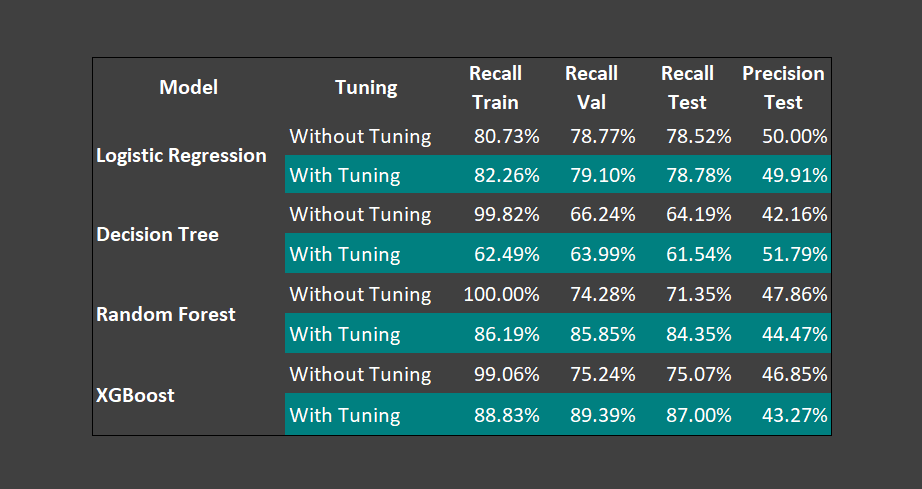

From the graph above, the following conclusions can be drawn:
1. Only logistic regression produces a recall that remains relatively consistent in both the untuned and hyperparameter-tuned models. Although recall on the test set is slightly higher for the tuned model, the difference is not significant.
2. The other three models without hyperparameter tuning exhibit signs of overfitting, as seen in the high recall on the training set, which drops significantly when applied to the validation and test sets.




These two findings highlight the importance of hyperparameter tuning in this churn modeling process. This is crucial for:
1. **Enhancing model performance** → Finding the best combination of hyperparameter values that yield optimal evaluation metrics (in this case, recall). This is evident from the recall that remains stable across various new data sets (validation and test).
2. **Avoiding overfitting or underfitting** → For example, a Decision Tree model with an excessively large max_depth may overfit, as seen in the training recall reaching 99.82% but dropping significantly to 64.19% on the test set. This occurs because the max_depth hyperparameter was not properly set. Tuning helps find the optimal balance, demonstrated by recall values from the tuned model that are free from overfitting.
3. **Improving generalization to new data** → A well-tuned model does not only perform well on the training data but also remains strong on validation/test data, as seen in the recall results of DT, RF, and XGB models.
4. **Maximizing model efficiency** → Some hyperparameters impact computational time, so tuning can help balance performance and efficiency.

## Best Model

The best model is selected based on the highest recall score.

Why? Because recall indicates how reliably the model can correctly predict churned customers. The higher the recall, the stronger and more effective the model is at identifying potential customer churn. This helps companies and stakeholders minimize high churn rates.

Based on the table above, **XGBoost achieves the highest recall score, making it the best-performing model** in this case compared to the others.

**NOTES:**

- The table also presents precision scores, which can be an important consideration from a business perspective.
- Precision measures how accurately the model predicts actual churned customers. For example, if the model predicts 80 customers will churn, but only 40 actually do, the precision would be 50%.
- In the four models analyzed, precision remains quite low (< 52%), meaning the model often misclassifies non-churn customers as churned customers.

Why does this matter for businesses?
- While this may not be a major issue, companies aiming to optimize their budget should consider it. A low precision score could result in unnecessary retention costs, such as offering discounts to customers who were never likely to churn.
- However, for businesses that follow the principle of "prevention is better than cure" and view budget as a lesser concern, recall score alone is sufficient to aid retention strategies moving forward.